# Sentiment analysis with BERT

In [1]:
# Google colab, once
# !pip install imblearn
# !wget "https://raw.githubusercontent.com/marciobda/PortugueseEmotionRecognitionWeakSupervision/refs/heads/main/test.csv"

In [2]:
#general purpose
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#data processing
import re, string

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

#transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel

#keras
import tensorflow as tf

#metrics
from sklearn.metrics import classification_report, confusion_matrix

#seed for reproducibility
SEED = 42

MODEL_NAME = 'full_bert_no_mask'
TRAIN_FILE = './../train_full_mask.csv'

#set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-v0_8")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)


2024-11-17 13:07:58.782331: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731859678.794491   96153 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731859678.798064   96153 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-17 13:07:58.811220: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


<Figure size 640x480 with 0 Axes>

In [3]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

I0000 00:00:1731859681.305772   96153 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9536 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:0c:00.0, compute capability: 8.6
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a B

In [4]:
emotions = ['Admiração', 'Diversão', 'Raiva', 'Aborrecimento', 'Aprovação', 'Confusão', 'Curiosidade', 'Desejo', 'Decepção', 'Nojo', 'Vergonha', 'Entusiasmo', 'Medo', 'Gratidão', 'Luto', 'Alegria', 'Amor', 'Nervosismo', 'Otimismo', 'Orgulho', 'Alívio', 'Remorso', 'Tristeza', 'Surpresa', 'Saudade', 'Inveja', 'Compaixão', 'Desaprovação']

## Loading the data

In [5]:
df = pd.read_csv(TRAIN_FILE, sep='\t', quoting=3 , engine='python')
df = df.dropna()

In [6]:
df_test = pd.read_csv('./../test.csv', sep='\t', quoting=3 , engine='python')
df_test = df_test.dropna()

### Remove duplicated tweets

In [7]:
df.info()
df.drop_duplicates(subset='tweet', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10612 entries, 0 to 10728
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   10612 non-null  object
 1   tweet      10612 non-null  object
 2   categoria  10612 non-null  object
dtypes: object(3)
memory usage: 331.6+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 10494 entries, 0 to 10728
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   10494 non-null  object
 1   tweet      10494 non-null  object
 2   categoria  10494 non-null  object
dtypes: object(3)
memory usage: 327.9+ KB


## Tweets analysis

In [8]:
df = df[['tweet', 'categoria']]
df_test = df_test[['tweet', 'categoria']]

In [9]:
# Remove punctuations, links, mentions and \r\n new line characers
def strip_all_entities(text):
    text = text.replace('\r','').replace('\n',' ').lower()
    text = re.sub(r'(?:\@|https?\://)\S+', '',text)
    text = re.sub(r'[^\x00-\x7f]','', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'

    banned_list = string.punctuation

    table = str.maketrans('','',banned_list)
    text = text.translate(table)

    return text

# Filter special characters such as & and $ present in some words
def filter_chars(text):
    sent = []
    for word in text.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    
    return ' '.join(sent)

# Remove multiple spaces
def remove_mult_spaces(text):
    return re.sub(r'\s\s+', ' ', text)

In [10]:
new_texts = []

for text in df.tweet:
    new_texts.append(remove_mult_spaces(filter_chars(strip_all_entities(text))))

df['clean_tweet'] = new_texts

In [11]:
new_texts_test = []

for text in df_test.tweet:
    new_texts_test.append(remove_mult_spaces(filter_chars(strip_all_entities(text))))

df_test['clean_tweet'] = new_texts_test

In [12]:
df['clean_tweet'].head()
df_test['clean_tweet'].head()

0    o thomas todo pitico saindo com os amigos se d...
1    fico impressionada com a inveja desse povo deu...
2    sim peguei uma virose do capeta acho que vomit...
3                         deus odeia o houston rockets
4                                   para eu vou chorar
Name: clean_tweet, dtype: object

In [13]:
df = df.sample(frac=1).reset_index(drop=True)
df_test = df_test.sample(frac=1).reset_index(drop=True)

In [14]:
df['categoria'] = df['categoria'].apply(lambda x: list(map(int, x.split(','))))
df_test['categoria'] = df_test['categoria'].apply(lambda x: list(map(int, x.split(','))))

### Train - Validation - Test split

In [15]:
VALIDATION_RATIO = 0.15
TEST_RATIO = 0.10

X_train =  df['clean_tweet']
X_test =  df_test['clean_tweet']
y_train = df['categoria']
y_test = df_test['categoria']

X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test ,test_size= TEST_RATIO/(TEST_RATIO + VALIDATION_RATIO), random_state=SEED)

print(df.shape, X_train.size, X_valid.size, X_test.size)

(10494, 3) 10494 1065 710


In [16]:
mlb = MultiLabelBinarizer(classes=range(28))  # Assuming there are 28 categories

y_train_le = y_train.copy()
y_valid_le = y_valid.copy()
y_test_le = y_test.copy()

y_train = mlb.fit_transform(y_train)
y_valid = mlb.transform(y_valid)
y_test = mlb.transform(y_test)

## BERT Emotion analysis

In [17]:
MAX_LEN = 128

def tokenize(data, max_len=MAX_LEN):
    input_ids = []
    attention_masks = []

    # Convert to list if it's a DataFrame/Series
    if hasattr(data, 'values'):
        data = data.values.tolist()

    for text in data:

        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',  # Added for consistency
            truncation=True,       # Added for safety
            return_attention_mask=True
        )

        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    return np.array(input_ids),np.array(attention_masks)

In [18]:
train_input_ids, train_attention_masks = tokenize(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(X_test, MAX_LEN)

### BERT modeling

In [19]:
def create_model(bert_model, max_len=MAX_LEN, num_labels=28):

    ## params ##
    opt = tf.keras.optimizers.AdamW(learning_rate=1e-5)
    loss = tf.keras.losses.BinaryCrossentropy()
    accuracy = tf.keras.metrics.BinaryAccuracy()

    input_ids = tf.keras.Input(shape=(max_len), dtype='int32')
    attention_maks = tf.keras.Input(shape=(max_len), dtype='int32')

    embeddings = bert_model([input_ids, attention_maks])[1]

    output = tf.keras.layers.Dense(num_labels, activation="sigmoid")(embeddings)

    model = tf.keras.models.Model(inputs=[input_ids, attention_maks], outputs=output)
    
    model.compile(optimizer=opt, loss=loss, metrics=accuracy)

    return model

In [20]:
model = create_model(bert_model, MAX_LEN)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_1[0][0]',             
 )                           ngAndCrossAttentions(last_   40         'input_2[0][0]']             
                             hidden_state=(None, 128, 7                                           
                             68),                                                             

In [21]:
history_bert = model.fit(
    [train_input_ids, train_attention_masks],
    y_train,
    validation_data=([val_input_ids, val_attention_masks], y_valid),
    epochs=4,
    batch_size=32
    )

Epoch 1/4


I0000 00:00:1731859704.771469   96276 service.cc:148] XLA service 0x7fa73af0ff70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731859704.771517   96276 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2024-11-17 13:08:24.777094: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1731859704.788153   96276 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1731859704.842112   96276 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


328/328 [==============================] - 108s 249ms/step - loss: 0.1972 - binary_accuracy: 0.9508 - val_loss: 0.1852 - val_binary_accuracy: 0.9558
Epoch 2/4
328/328 [==============================] - 80s 243ms/step - loss: 0.1470 - binary_accuracy: 0.9643 - val_loss: 0.1882 - val_binary_accuracy: 0.9558
Epoch 3/4
328/328 [==============================] - 80s 243ms/step - loss: 0.1451 - binary_accuracy: 0.9643 - val_loss: 0.1867 - val_binary_accuracy: 0.9559
Epoch 4/4
328/328 [==============================] - 80s 244ms/step - loss: 0.1405 - binary_accuracy: 0.9646 - val_loss: 0.1765 - val_binary_accuracy: 0.9563


### BERT Results

In [22]:
result_bert = model.predict([test_input_ids,test_attention_masks])

23/23 [==============================] - 4s 94ms/step


In [23]:
def conf_matrix(y, y_pred, title):
    fig, ax =plt.subplots(figsize=(40,40))
    labels=emotions
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":20})
    plt.title(title, fontsize=30)
    ax.xaxis.set_ticklabels(labels, fontsize=20) 
    ax.yaxis.set_ticklabels(labels, fontsize=20)
    ax.set_ylabel('Test', fontsize=22)
    ax.set_xlabel('Predicted', fontsize=22)
    plt.show()


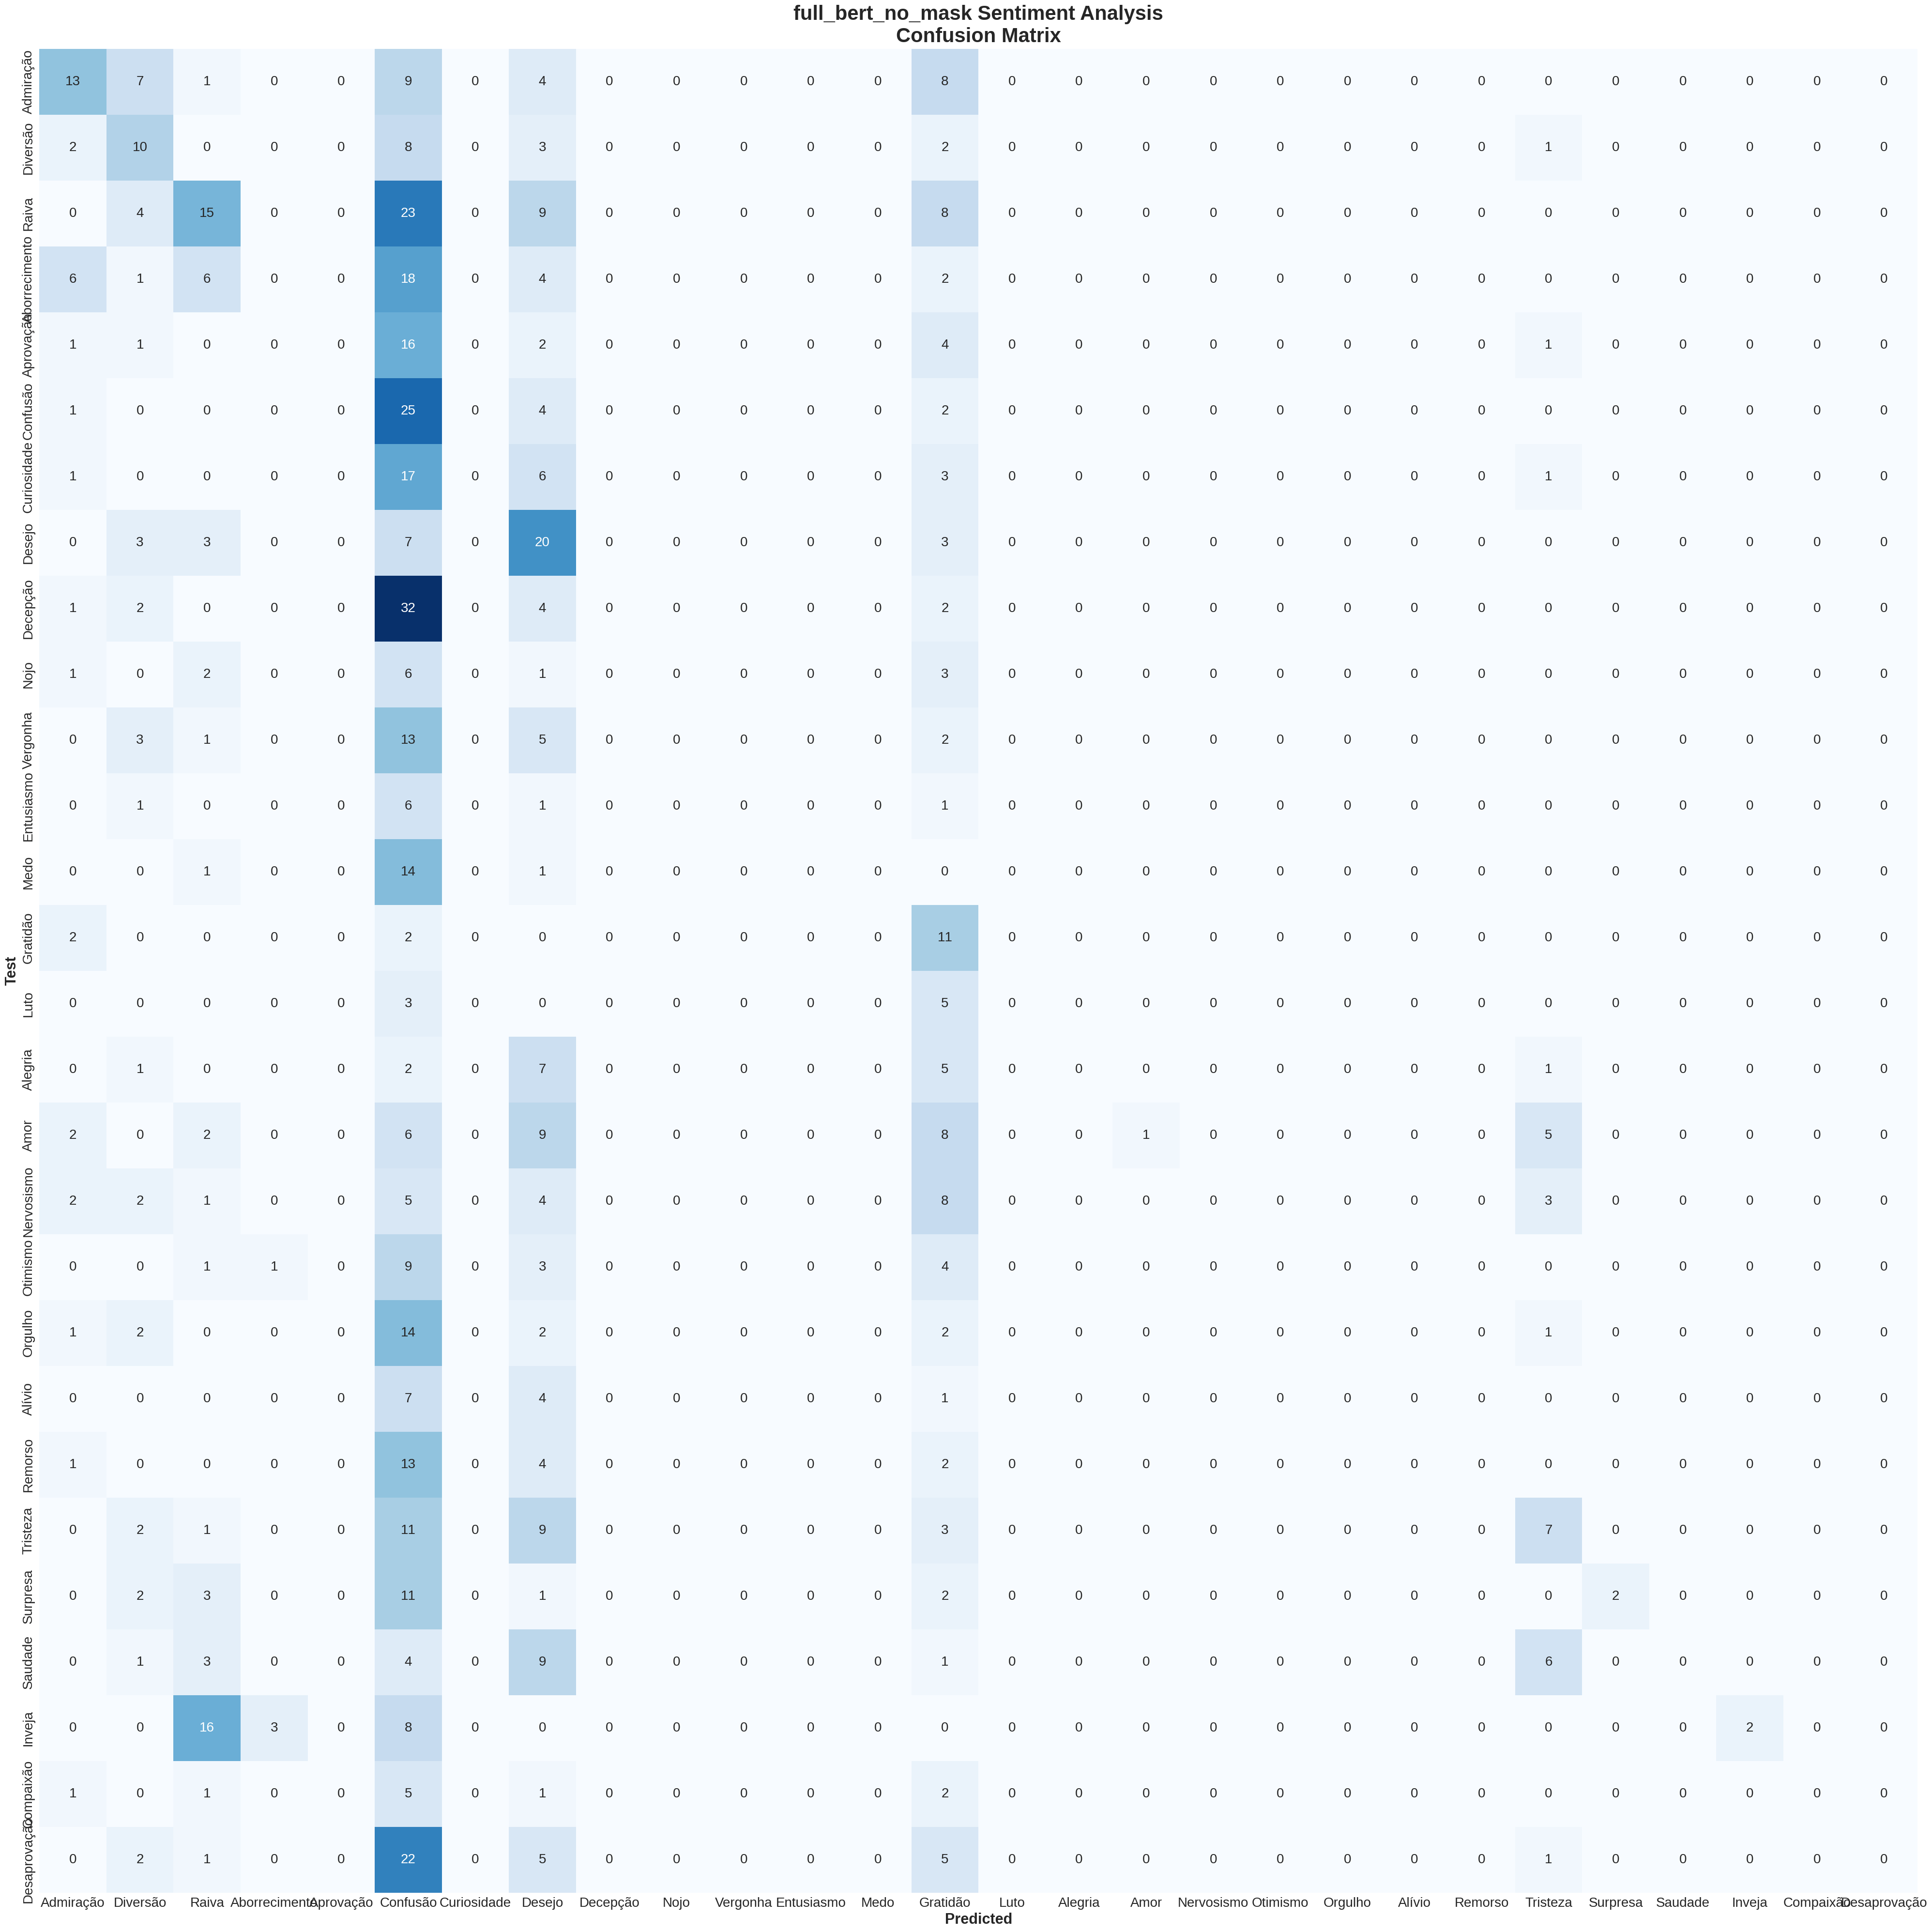

In [24]:
y_pred_bert =  np.zeros_like(result_bert)
y_pred_bert[np.arange(len(y_pred_bert)), result_bert.argmax(1)] = 1

conf_matrix(y_test.argmax(1), y_pred_bert.argmax(1),f'{MODEL_NAME} Sentiment Analysis\nConfusion Matrix')

In [25]:
print(f'\tClassification Report for {MODEL_NAME}:\n\n',classification_report(y_test, y_pred_bert, target_names=emotions))

	Classification Report for full_bert_no_mask:

                precision    recall  f1-score   support

    Admiração       0.37      0.31      0.34        42
     Diversão       0.23      0.37      0.28        27
        Raiva       0.26      0.25      0.26        59
Aborrecimento       0.00      0.00      0.00        38
    Aprovação       0.00      0.00      0.00        29
     Confusão       0.08      0.79      0.15        33
  Curiosidade       0.00      0.00      0.00        31
       Desejo       0.17      0.53      0.26        40
     Decepção       0.00      0.00      0.00        47
         Nojo       0.00      0.00      0.00        13
     Vergonha       0.00      0.00      0.00        28
   Entusiasmo       0.00      0.00      0.00        21
         Medo       0.00      0.00      0.00        17
     Gratidão       0.12      0.71      0.21        17
         Luto       0.00      0.00      0.00         9
      Alegria       0.00      0.00      0.00        25
         Amor   

/home/marciobda/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Testing the model

In [26]:
def prepare_text(text, tokenizer, max_len=128):

    encoded_text = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='tf'
    )

    return encoded_text['input_ids'], encoded_text['attention_mask']

def predict_category(text, model, tokenizer, mlb, threshold=0.5):

    input_ids, attention_mask = prepare_text(text, tokenizer)

    predictions = model.predict([input_ids, attention_mask])

    print(np.round(predictions.tolist(), 2))
    
   # Apply threshold to convert probabilities to binary values
    binary_predictions = (predictions >= threshold).astype(int)

    # Convert back to original category
    predicted_labels = mlb.inverse_transform(binary_predictions)

    emotions_found = []

    for label in predicted_labels[0]:
        emotions_found.append(f'{label} {emotions[label]}')

    return emotions_found

In [27]:
text = "Eu acho que estou empolgado com esse trabalho apesar da dificuldade"
predicted_category = predict_category(text, model, tokenizer, mlb, .3)

print(f"Predicted categories: {predicted_category}")

1/1 [==============================] - 2s 2s/step
[[0.06 0.03 0.04 0.02 0.01 0.06 0.02 0.05 0.02 0.02 0.01 0.02 0.03 0.11
  0.   0.02 0.03 0.02 0.03 0.02 0.03 0.02 0.03 0.02 0.02 0.01 0.02 0.01]]
Predicted categories: []


### Saving the model

In [28]:
# import os

# model_save_path = f'{MODEL_NAME}_model'
# os.makedirs(model_save_path, exist_ok=True)

# model.save(model_save_path)
# tokenizer.save_pretrained(model_save_path)